# Fitting to time tag data natively

This notebook is intended to give an example of how to fit an estimated photon arrival rate to time tags (without binning).  

This notebook uses simulated data which.  To generate this data, you will need a function in the repo

    NCAR/deadtime-sim-ptv
    
This notebook utilizes PyTorch to perform the fitting routine.

Our aim is to obtain an estimate of $\lambda(t)$, the photon arrival rate, as a function of time $t$ (relative to laser pulse firing).  We obtain this using a list of $N$ time tags where photons arrived $\mathbf{t} =  \lbrace t_n \rbrace_{n=1}^N$.

For a Poisson point process the probability that the random photon arrivals $\mathbf{T}$ correspond the observations is

$\mathbb{P}\left( \lbrace T_n = t_n \rbrace_{n=1}^N \right) = e^{-\Lambda(t_{max})}\prod_{n=1}^{N} \lambda(t_n)$

where

$\Lambda(t) = \int_0^{t} \lambda(t') dt'$

and $t_{max}$ is the maximum time in the retrieval.

The above probability accounts for one laser shot.  For multiple shots, the PDFs should be multiplied.  In that case, for $L$ laser shots we obtain

$\mathbb{P}\left( \lbrace T_n = t_n \rbrace_{n=1}^N \right) = e^{-L \Lambda(t_{max})}\prod_{n=1}^{N} \lambda(t_n)$

where the list of photons comprises all arrivals from all laser shots.

In order to perform a fit, we aim to minimize the negative log-likelihood (NLL) of the PDF.  This gives the loss function

$\mathcal{L}[\lambda(t)] = L \Lambda(t_{max}) - \sum_{n=1}^{N} \ln\lambda(t_n)$

From the above definition, it becomes clear that it is useful to have basis functions for $\lambda(t)$ that can be integrated analytically.  For this example, we use a Gaussian target in a constant background

$\lambda(t) = A \exp\left( -\frac{(t-\mu)^2}{2\sigma^2}\right) + b$

where the parameters $A$, $\mu$, $\sigma$ and $b$ must be estimated in the fitting routine.  The integral of the above arrival rate basis function is

$\Lambda(t) = \frac{1}{2} A \sigma \sqrt{2\pi} \left[1 + erf\left(\frac{t-\mu}{\sigma\sqrt{2}}\right)\right] + b t$

where $erf$ is the Gauss Error Function.

### Accounting for Dead time

Deadtime in the detector or acquisition system changes the detection PDF.  The probability of detection within the deadtime after a prior photon detection is zero.  In aggregate, each detection serves to surpress the probability of subsequent deetections.  The formal derivation is not trivial, but resulting PDF is

$\mathbb{P}\left( \lbrace T_n = t_n \rbrace_{n=1}^N \right) = \prod_{n=1}^N \mathbf{1}\lbrace t_n \ge t_{n-1} +\tau_d \rbrace \lambda(t_n)\exp\left[-\Lambda(t_n)+\Lambda(t_{n-1}+\tau_D) \right]$

where $\mathbf{1}\lbrace t_n \ge t_{n-1}$ is $1$ when its argument is true and $0$ when the argument is false.  This term is not needed when we formulate the NLL, because, assuming our model of the detection process is correct, we will never detect any photons inside of the deadtime.  Taking the negative of the log of the PDF gives

$\mathcal{L}[\lambda(t)] = \sum_{n=1}^{N} \left[\Lambda(t_n)-\Lambda(t_{n-1}+\tau_D) -  \ln\lambda(t_n) \right]$

This likelihood function is very similar to the one we use for the Poisson noise model.  The main distiction is that the integral term only includes instances when the detection system is armed.  Note that as the deadtime approaches zero, this NLL will approach that of the Poisson.

In [2]:
import os,sys
import numpy as np
import xarray as xr
import torch
import glob
import matplotlib.pyplot as plt

In [3]:
dtype = torch.float64
device = torch.device("cpu")

In [4]:
# import library for simulating Poisson point processes
dirP_str = os.path.join(os.environ['HOME'], 
                    'Documents',
                    'GitHub',
                    'deadtime-sim-ptv',
                    'python',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
    
import sim_deadtime_utils as sim

In [5]:
# picoquant relative time max value
rollover_count = 33554432

In [6]:
def chebyshev_poly(order:int)->torch.tensor:
    """
    Generates the coefficient matrix for chebyshev polynomials
    where the polynomial is generated using matrix multiplication
    [1, x, x^2, ... , x^N] @ coef_mat
    """
    if order == 0:
        return torch.tensor([1],dtype=dtype,device=device)
    elif order == 1:
        return torch.tensor([1,0],[0,1],dtype=dtype,device=device)
    else:
        coef_mat = torch.zeros((order+1,order+1),dtype=dtype,device=device)
        coef_mat[0,0] = 1
        coef_mat[1,1] = 1
        for idx in range(2,order+1):
            coef_mat[1:,idx] = 2*coef_mat[:-1,idx-1]
            coef_mat[:,idx] -= coef_mat[:,idx-2]
    
    return coef_mat

def chebyshev_poly_int(order:int)->torch.tensor:
    """
    Generates the coefficient matrix for integral of chebyshev polynomials
    where the integral of the polynomial is generated using matrix multiplication
    [x, x^2, ... , x^(N+1)] @ coef_mat
    """
    if order == 0:
        return torch.tensor([1],dtype=dtype,device=device)
    elif order == 1:
        return torch.tensor([1,0],[0,0.5],dtype=dtype,device=device)
    else:
        # rescale by the integral polynomial power
        coef_mat = chebyshev_poly(order)/(torch.arange(order+1,dtype=dtype,device=device)+1)[:,None]
        
    return coef_mat

In [8]:
def int_hist(t_int,sync_arr,tt_arr,tt_sync,tD,split=2):
    """
    Create a histogram to approximate integration
    t_int: np.array
        integration time grid
    sync_arr: np.ndarray
        array containing a list of the sync identifiers
    tt_arr; np.ndarray
        array containing all the time tags
    tt_sync: np.ndarray
        array containing the sync identifier corresponding
        to tt_arr
    tD: float
        deadtime
    split: int
        number of datasets to split into for fit/validation/test
    """
    h_tt_lst = []
    for idx in range(split):
        h_tt_lst.append(np.zeros(t_int))
    
    
    int_dt_lst = []
    int_t_lst = []
    dt = np.mean(np.diff(t_int))
    last_t = -1e3
    split_idx = 0
    for sync_idx in sync_arr:
        tt_sub_arr = tt_arr[np.where(tt_sync == sync_idx)]
        if tt_sub_arr.size == 0:
            # empty data
            idx1 = np.argmin(np.abs(t_int-(last_t+tD)))
            h_tt_lst[split_idx][idx_1:] += dt
        else:
            
        split_idx = np.mod(split_idx+1,split)
            
        

IndentationError: expected an indented block (<ipython-input-8-050cef9f46f3>, line 36)

# Load Data

In [342]:
# data_path = os.path.join(os.environ['HOME'],'Documents','CUBL','2022_04_15_DeadtimeTest','netcdf')
# data_path = os.path.join(os.environ['HOME'],'Documents','CUBL','SPCM_data_OD_iterate_20230130','netcdf')

# data_path = os.path.join(os.environ['HOME'],'Documents','CUBL','2023.01.31.Part1','netcdf.Part1')
# data_path = os.path.join(os.environ['HOME'],'Documents','CUBL','2023.01.31.Part2','netcdf.Part2')
data_path = os.path.join(os.environ['HOME'],'Documents','CUBL','2023.01.31.Part3','netcdf.Part3')


In [343]:
file_lst = sorted(glob.glob(os.path.join(data_path,'*.ARSENL.nc')))
for fidx,file in enumerate(file_lst):
    print(f"{fidx:02d}.) "+file.split(os.sep)[-1])

00.) OD45_Dev_0_-_2023-01-31_18.06.24_OD4.7.ARSENL.nc
01.) OD46_Dev_0_-_2023-01-31_16.33.53_OD4.4.ARSENL.nc
02.) OD47_Dev_0_-_2023-01-31_16.37.15_OD4.6.ARSENL.nc
03.) OD48_Dev_0_-_2023-01-31_18.09.40_OD4.9.ARSENL.nc
04.) OD49_Dev_0_-_2023-01-31_16.40.28_OD4.8.ARSENL.nc
05.) OD50_Dev_0_-_2023-01-31_16.43.48_OD5.0.ARSENL.nc


In [249]:
file_sel = 0
ds = xr.open_dataset(file_lst[file_sel])

In [250]:
tD = 250e-9 # deadtime of PicoQuant Board

# set limits on what to processes (in ps)
min_time = 29.9e3
max_time = 33.4e3
t_int = np.linspace(min_time,max_time,1000)  # integration time histogram
t_plt = np.linspace(min_time*1e-12,max_time*1e-12,200)

In [251]:
ds

<xarray.Dataset>
Dimensions:              (time_tag_index: 1593623, sync_index: 1603141)
Coordinates:
  * sync_index           (sync_index) uint64 1 2 3 4 ... 1603139 1603140 1603141
Dimensions without coordinates: time_tag_index
Data variables:
    time_tag             (time_tag_index) int64 ...
    time_tag_diff        (time_tag_index) int64 ...
    time_tag_sync_index  (time_tag_index) uint64 ...
    sync_ux_time         (sync_index) datetime64[ns] ...
    sync_ux_time_us      (sync_index) timedelta64[ns] ...
    sync_diff_time       (sync_index) int64 ...
    sync_delta           (sync_index) int64 ...

In [252]:
# identify data where the sync spacing is valid
sync_time_diff = ds['sync_delta'].values*ds['time_tag'].attrs['clock conversion']
invalid_sync_idx = np.unique(ds['sync_index'].values[np.where((sync_time_diff < 65e6) | (sync_time_diff > 75e6))[0]-1])
valid_sync_idx = ds['sync_index'].values[np.where((sync_time_diff > 65e6) & (sync_time_diff < 75e6))[0]-1]

In [259]:
1/np.median(sync_time_diff*1e-12)

14146.447561771347

In [261]:
ds['time_tag'].attrs

{'description': 'Photon relative time tag, with 25 ps per count',
 'units': 'clock counts',
 'clock units': 'ps',
 'device': 'dev',
 'clock conversion': 25.0}

In [253]:
time_tags = ds['time_tag'].values*ds['time_tag'].attrs['clock conversion']
time_tag_sync = ds['time_tag_sync_index'].values
time_tag_diff = ds['time_tag_diff'].values*ds['time_tag'].attrs['clock conversion']

# get the profile end times from sync time
sync_cnt_end = np.diff(ds['sync_diff_time'].values)
# neg_prof_idx = np.where(sync_t_end < 0)
# sync_cnt_end[neg_prof_idx] = sync_cnt_end[neg_prof_idx]+rollover_count+1
# sync_cnt_end = np.concatenate((sync_cnt_end,sync_cnt_end[-1:]))
# sync_t_end = sync_cnt_end*ds['time_tag'].attrs['clock conversion']

# filter out invalid data where the sync pulse got missed
valid_time_tag_idx = np.where(np.in1d(time_tag_sync,valid_sync_idx))
time_tags = time_tags[valid_time_tag_idx]
time_tag_sync = time_tag_sync[valid_time_tag_idx]
time_tag_diff = time_tag_diff[valid_time_tag_idx]
# sync_t_end = sync_t_end[valid_sync_idx]

# create an array that indicates when the acquisition system
# was armed for detection prior to each detection
# TODO switch to integration limits t_int_lo and t_int_hi
#    this should probably go above the valid index filtering
# t_int_lo = time_tags + tD*1e12
# t_lo_sync = time_tag_sync.copy()
# t_over_idx = np.where(t_int_lo >= sync_t_end[])
# time_arm = time_tags-time_tag_diff+tD*1e12
# time_arm = np.maximum(np.minimum(time_arm,max_time),min_time)

# thin the data into training and validation sets
sync_idx_trn = valid_sync_idx[::2]
sync_idx_vld = valid_sync_idx[1::2]

# training time tags
trn_idx = np.where(np.in1d(time_tag_sync,sync_idx_trn))
t_det_trn = time_tags[trn_idx]
tag_sync_idx_trn = time_tag_sync[trn_idx]
t_diff_trn = time_tag_diff[trn_idx]
# time_arm_vld = time_arm[trn_idx]
Ntrn = sync_idx_trn.size  # number of training laser shots
Nemty_trn = np.sum(np.logical_not(np.in1d(sync_idx_trn,tag_sync_idx_trn)))


# validation time tags
vld_idx = np.where(np.in1d(time_tag_sync,sync_idx_vld))
t_det_vld = time_tags[vld_idx]
tag_sync_idx_vld = time_tag_sync[vld_idx]
t_diff_vld = time_tag_diff[vld_idx]
# time_arm_vld = time_arm[vld_idx]
Nvld = sync_idx_vld.size  # number of validation laser shots
Nemty_trn = np.sum(np.logical_not(np.in1d(sync_idx_vld,tag_sync_idx_vld)))

In [254]:
invalid_sync_idx

array([  25771,  489492,  489941,  819865,  917148, 1141903, 1191402,
       1476767, 1603141], dtype=uint64)

In [ ]:
# define detector deadtime in seconds
detector_deadtime = 28.85e-9
ds['sync_delta'].values

In [332]:
# def int_hist(t_int,sync_arr,tt_arr,tt_sync,tD,split=2):
"""
Create a histogram to approximate integration
t_int: np.array
    integration time grid
sync_arr: np.ndarray
    array containing a list of the sync identifiers
tt_arr; np.ndarray
    array containing all the time tags
tt_sync: np.ndarray
    array containing the sync identifier corresponding
    to tt_arr
tD: float
    deadtime
split: int
    number of datasets to split into for fit/validation/test
"""
dt = 0.1e3
t_bins = np.arange(0,5000e3,dt)
sync_arr = ds['sync_index'].values
sync_idx_arr = (np.where((sync_time_diff > 65e6) & (sync_time_diff < 75e6))[0]-1)[:2000000]
# sync_arr = valid_sync_idx
sync_diff = sync_time_diff
tt_sync = time_tag_sync
tt_arr = time_tags
tD = 28.85*1e3
split = 2


h_tt_lst = []
h_int_lst = []
shot_count_lst = []
for idx in range(split):
    h_tt_lst.append(np.zeros(t_bins.size-1))
    h_int_lst.append(np.zeros(t_bins.size-1))
    shot_count_lst.append(0)


int_dt_lst = []
int_t_lst = []
# dt = np.median(np.diff(t_bins))
last_t = -1e3
last_sync = -1e3
split_idx = 0
for sync_idx in sync_idx_arr:
    shot_count_lst[split_idx] += 1
    if sync_idx > last_sync + 1:
        last_t = last_t - sync_diff[sync_idx-1]
        
    tt_sub_arr = tt_arr[np.where(tt_sync == sync_idx)]
    if tt_sub_arr.size == 0:
        # empty data
        idx_1 = np.argmin(np.abs(t_bins-(last_t+tD)))
        h_int_lst[split_idx][idx_1:] += dt
        
    else:
        # not empty data
        h_tt_lst[split_idx] += np.histogram(tt_sub_arr,bins=t_bins)[0]
        tt_sub_arr = np.concatenate((np.array([last_t]),tt_sub_arr))
        dt_sub_arr = tt_sub_arr+tD
        int_hist = 1-np.sum((tt_sub_arr[:,np.newaxis] <= t_bins[np.newaxis,:]) * (dt_sub_arr[:,np.newaxis] > t_bins[np.newaxis,:]),axis=0)
        h_int_lst[split_idx] += int_hist[:-1]*dt
        
        last_t = np.max(tt_sub_arr) - sync_diff[sync_idx]

    split_idx = np.mod(split_idx+1,split)

In [335]:
shot_count_lst

[801566, 801566]

801566


(0.0, 100.0)

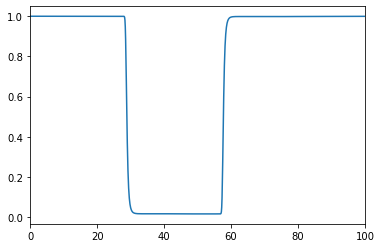

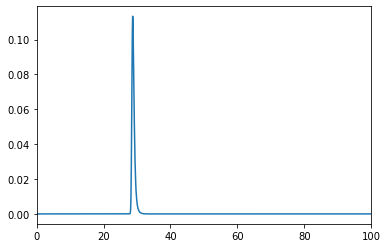

In [334]:
print(shot_count_lst[1])
plt.figure()
plt.plot(t_bins[:-1]*1e-3,h_int_lst[1]/dt/shot_count_lst[1])
plt.xlim([0,100])

plt.figure()
plt.plot(t_bins[:-1]*1e-3,h_tt_lst[1]/shot_count_lst[1])
plt.xlim([0,100])

In [318]:
sync_idx

296436

In [320]:
sync_idx_arr

array([      0,       1,       2, ..., 1603137, 1603138, 1603139])

In [276]:
tt_sub_arr

array([29200.])

In [297]:
tt_sub_arr = np.array([29200, 186530])
dt_sub_arr = tt_sub_arr+tD

(0.0, 1000000.0)

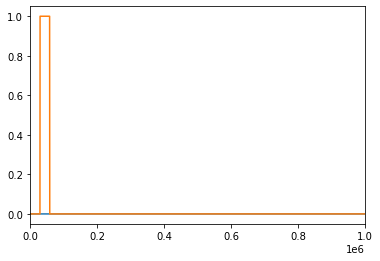

In [310]:

plt.figure()
plt.plot(t_bins,((tt_sub_arr[:,np.newaxis] <= t_bins[np.newaxis,:]) * (dt_sub_arr[:,np.newaxis] > t_bins[np.newaxis,:])).T)
# plt.plot(t_bins,1-np.sum((tt_sub_arr[:,np.newaxis] <= t_bins[np.newaxis,:]) * (dt_sub_arr[:,np.newaxis] > t_bins[np.newaxis,:]),axis=0))
plt.xlim([0,1e6])

In [286]:
np.stack((tt_sub_arr,dt_sub_arr),axis=1) > t_bins

ValueError: operands could not be broadcast together with shapes (2,2) (50000,) 

In [271]:
np.sum(h_tt_lst[0])

5.0

In [272]:
h_int_lst[0]

array([100., 100., 100., ..., 100., 100., 100.])

In [269]:
dt

100.00000000000001

Text(0.5, 0, 'time [ns]')

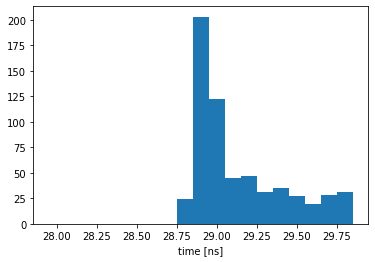

In [255]:
h_time_tag_diff = np.histogram(time_tag_diff,bins=np.arange(28e3,30e3,0.1e3))
plt.figure()
plt.bar(h_time_tag_diff[1][:-1]*1e-3,h_time_tag_diff[0],width=np.diff(h_time_tag_diff[1]*1e-3))
# plt.plot(h_time_tag_diff[1][:-1]*1e-3,h_time_tag_diff[0])
plt.xlabel('time [ns]')

In [337]:
ds['time_tag'].attrs

{'description': 'Photon relative time tag, with 25 ps per count',
 'units': 'clock counts',
 'clock units': 'ps',
 'device': 'dev',
 'clock conversion': 25.0}

In [338]:
np.min(time_tag_diff)*1e-3

28.85

In [339]:
np.min(time_tag_diff)/ds['time_tag'].attrs['clock conversion']

1154.0

In [221]:
hist_lst = []

In [243]:

h_time_tag = np.histogram(time_tags,bins=np.arange(0,250e3,0.1e3))
# plt.figure()
# plt.bar(h_time_tag[1][:-1]*1e-3,h_time_tag[0],width=np.diff(h_time_tag[1]*1e-3))
hist_lst.append(h_time_tag)

(0.0, 100.0)

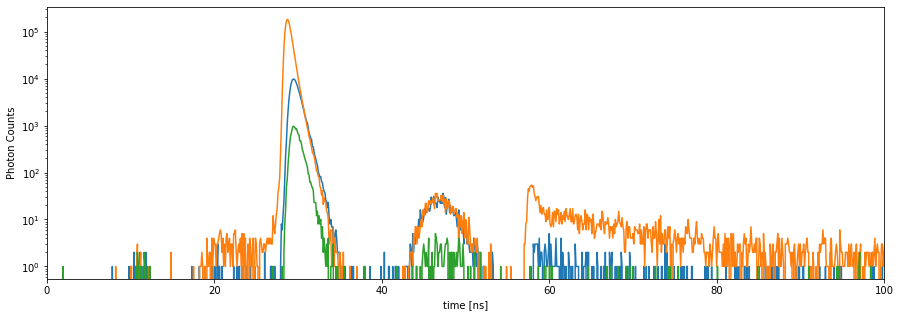

In [246]:
plt.figure(figsize=(15,5))
for htt in hist_lst:
    plt.plot(htt[1][:-1]*1e-3,htt[0])
# plt.plot(h_time_tag[1][:-1]*1e-3,h_time_tag[0])
plt.yscale('log')
plt.ylabel('Photon Counts')
plt.xlabel('time [ns]')
plt.xlim([0,100])

In [172]:
4*500e-9*3e8/2

300.0

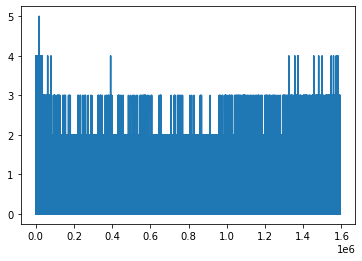

In [23]:
plt.figure()
plt.plot(np.diff(time_tag_sync))

In [14]:
np.sum(np.logical_not(np.in1d(sync_idx_trn,time_tag_sync[trn_idx])))

35

In [15]:
t_det_trn = t_det_trn[np.where((t_det_trn > min_time) & (t_det_trn < max_time))]
t_det_vld = t_det_vld[np.where((t_det_vld > min_time) & (t_det_vld < max_time))]

In [16]:
t_det_trn *= 1e-12
t_det_vld *= 1e-12

In [17]:
print(f"Timing Board Clock: {ds['time_tag'].attrs['clock conversion']} "+ds['time_tag'].attrs['clock units'])

Timing Board Clock: 25.0 ps


# Perform Fit Using PyTorch
Assume the target is described by a Gaussian with a constant background

In [18]:
# convert training and validation data to 
# tensor type
t_phot_fit_tnsr = torch.tensor(t_det_trn,dtype=dtype,device=device)
t_phot_val_tnsr = torch.tensor(t_det_vld,dtype=dtype,device=device)

## Polynomial Fit

In [19]:
# build the fit model as a NN module

class Fit_Poly_Poisson(torch.nn.Module):
    def __init__(self,t,t_min,t_max,Ntrn,order,mu=0.1,eps=1e-10):
        """
        Instantiate and initialize the fit parameters.
        t : torch.tensor
            observed time tags
        t_min : float
            minimimum time in retrieval domain
        t_max : float
            maximum time in the retrieval domain
        Ntrn : int
            number of laser shots
        order : int
            fit polynomial order
        mu : float
            scaler for approximation of barrier function
            mu > 0
            approximation is more accurate for larger mu
        eps : float
            precision limit for positive result
        """
        super().__init__()
        
        self.order = order
        self.t_min = t_min # maximum time evaluated in integral term
        self.t_max = t_max # maximum time evaluated in integral term
        self.Ntrn = Ntrn
        
        self.poly_coef = chebyshev_poly(order)
#         self.int_coef = chebyshev_poly_int(order)

        self.t_int = np.linspace(t_min,t_max,1000)
        self.dt_int = self.t_int[1] - self.t_int[0]
        
        self.treg = self.reg_time(t) # (t - 0.5*(t_max+t_min))/(t_max-t_min)
        self.treg_int = self.reg_time(torch.tensor(self.t_int,dtype=dtype,device=device))
#         self.dt_int = self.treg_int[1] - self.treg_int[0]
#         self.treg_int = 2*torch.tensor([t_min,t_max],dtype=dtype,device=device)/(t_max-t_min) - 1
        
        self.x_mat = torch.ones((self.treg.shape[0],order+1),device=device,dtype=dtype)
        self.x_int = torch.ones((self.treg_int.shape[0],order+1),device=device,dtype=dtype)
        for idx in range(1,order+1):
            self.x_mat[:,idx] = self.treg**idx
            self.x_int[:,idx] = self.treg_int**idx
            
#         self.x_int = self.x_mat*self.treg[:,None]
        
        self.p_fit = torch.matmul(self.x_mat,self.poly_coef)
        self.p_int = torch.matmul(self.x_int,self.poly_coef)
#         self.p_int = torch.matmul(self.x_int,self.int_coef)
        
        # define actual fit coefficients
        # torch.zeros(order+1,1,dtype=dtype,device=device)
        
        # Polynoial Coefficients
        self.fit_coeff = torch.nn.Parameter(torch.tensor((np.random.rand(order+1,1)-0.5)*np.log(1e5),dtype=dtype,device=device))
        
#         self.fit_coeff = torch.nn.Parameter(torch.rand((order+1,1),dtype=dtype,device=device)*\
#                                             torch.exp(-10.0*torch.arange(order+1,dtype=dtype,device=device)[:,None]))
        # Lagrange Multipliers
#         self.mu = mu  
        
#         self.scale = torch.nn.Parameter(torch.rand((1,1),dtype=dtype,device=device)+np.log(1e9))

    def forward(self):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        model_out, integral = self.eval_model()
        
        integral_out = integral[-1]*self.dt_int
        
        loss = self.Ntrn*integral_out-torch.sum(torch.log(model_out))
        
        # apply log barrier function
#         loss = self.mu * loss - torch.sum(torch.log(model_out))
        
        return loss
    
    def set_mu(self,mu):
        self.mu = mu
    
    def set_vld(self,t,Nvld):
        
        self.Nvld = Nvld
        treg = self.reg_time(t)
        self.x_mat_vld = self.x_matrix(treg)
        self.p_fit_vld = torch.matmul(self.x_mat_vld,self.poly_coef)
        
    def vld_loss(self):
        
        model_out, integral = self.eval_vld()
        
        integral_out = integral[-1]*self.dt_int
        
        loss = self.Nvld*integral_out-torch.sum(torch.log(model_out)) 
        
        return loss
        
    
    def reg_time(self,t):
        return (t - 0.5*(self.t_max+self.t_min))/(self.t_max-self.t_min)
    
    def x_matrix(self,treg):
        x_mat = torch.ones((treg.shape[0],self.order+1),device=device,dtype=dtype)
        for idx in range(1,self.order+1):
            x_mat[:,idx] = treg**idx
            
        return x_mat
    
    def eval_model(self):
        model_out = torch.exp(torch.matmul(self.p_fit,self.fit_coeff))
        integral = torch.cumsum(torch.exp(torch.matmul(self.p_int,self.fit_coeff)),0)*self.dt_int
        return model_out, integral
    
    def eval_vld(self):
        model_out = torch.exp(torch.matmul(self.p_fit_vld,self.fit_coeff))
        integral = torch.cumsum(torch.exp(torch.matmul(self.p_int,self.fit_coeff)),0)*self.dt_int
        return model_out, integral
        
    def eval_new(self,t):
        treg = self.reg_time(t)
        x_mat = self.x_matrix(treg)
        p_fit = torch.matmul(x_mat,self.poly_coef)
        model_out = torch.exp(torch.matmul(p_fit,self.fit_coeff))*self.dt_int
        
        integral = torch.cumsum(torch.exp(torch.matmul(self.p_int,self.fit_coeff)),0)*self.dt_int
        
#         integral_out = integral[1] - integral[0]
        
        return model_out, integral

# class Fit_Poly_Poisson(torch.nn.Module):
#     def __init__(self,t,t_min,t_max,Ntrn,order,eps=1e-10):
#         """
#         Instantiate and initialize the fit parameters.
#         t : torch.tensor
#             observed time tags
#         t_min : float
#             minimimum time in retrieval domain
#         t_max : float
#             maximum time in the retrieval domain
#         Ntrn : int
#             number of laser shots
#         order : int
#             fit polynomial order
#         eps : float
#             precision limit for positive result
#         """
#         super().__init__()
        
#         self.order = order
#         self.t_min = t_min # maximum time evaluated in integral term
#         self.t_max = t_max # maximum time evaluated in integral term
#         self.Ntrn = Ntrn
        
#         self.poly_coef = chebyshev_poly(order)
#         self.int_coef = chebyshev_poly_int(order)
        
#         self.treg = self.reg_time(t) # (t - 0.5*(t_max+t_min))/(t_max-t_min)
#         self.treg_int = self.reg_time(torch.tensor([t_min,t_max],dtype=dtype,device=device))
# #         self.treg_int = 2*torch.tensor([t_min,t_max],dtype=dtype,device=device)/(t_max-t_min) - 1
        
#         self.x_mat = torch.ones((self.treg.shape[0],order+1),device=device,dtype=dtype)
#         self.x_int = torch.ones((2,order+1),device=device,dtype=dtype)
#         for idx in range(1,order+1):
#             self.x_mat[:,idx] = self.treg**idx
#             self.x_int[:,idx] = self.treg_int**(idx+1)
            
# #         self.x_int = self.x_mat*self.treg[:,None]
        
#         self.p_fit = torch.matmul(self.x_mat,self.poly_coef)
#         self.p_int = torch.matmul(self.x_int,self.int_coef)
        
#         # define actual fit coefficients
#         # torch.zeros(order+1,1,dtype=dtype,device=device)
        
#         # Polynoial Coefficients
#         self.fit_coeff = torch.nn.Parameter(torch.rand((order+1,1),dtype=dtype,device=device)*\
#                                             torch.exp(-10.0*torch.arange(order+1,dtype=dtype,device=device)[:,None]))
#         # Lagrange Multipliers
#         self.mu = torch.nn.Parameter(torch.rand(self.treg.shape[0],1,dtype=dtype,device=device))  
        
#         self.scale = torch.nn.Parameter(torch.rand((1,1),dtype=dtype,device=device)+np.log(1e9))

#     def forward(self):
#         """
#         Forward model the profile for input time t.
#         Also return the integral.
#         """
#         # calculate all the actual fit parameters
#         model_out, integral = self.eval_model()
        
#         integral_out = integral[1] - integral[0]
        
#         loss = self.Ntrn*integral_out-torch.sum(torch.log(model_out)) - torch.matmul(torch.exp(self.mu).T,model_out)
        
#         return loss
    
#     def set_vld(self,t,Nvld):
        
#         self.Nvld = Nvld
#         treg = self.reg_time(t)
#         self.x_mat_vld = self.x_matrix(treg)
#         self.p_fit_vld = torch.matmul(self.x_mat_vld,self.poly_coef)
        
#     def vld_loss(self):
        
#         model_out, integral = self.eval_vld()
        
#         integral_out = integral[1] - integral[0]
        
#         loss = self.Nvld*integral_out-torch.sum(torch.log(model_out)) 
        
#         return loss
        
    
#     def reg_time(self,t):
#         return (t - 0.5*(self.t_max+self.t_min))/(self.t_max-self.t_min)
    
#     def x_matrix(self,treg):
#         x_mat = torch.ones((treg.shape[0],self.order+1),device=device,dtype=dtype)
#         for idx in range(1,self.order+1):
#             x_mat[:,idx] = treg**idx
            
#         return x_mat
    
#     def eval_model(self):
#         model_out = torch.exp(self.scale)*torch.matmul(self.p_fit,self.fit_coeff)
#         integral = torch.exp(self.scale)*torch.matmul(self.p_int,self.fit_coeff)
#         return model_out, integral
    
#     def eval_vld(self):
#         model_out = torch.exp(self.scale)*torch.matmul(self.p_fit_vld,self.fit_coeff)+1e-20
#         integral = torch.exp(self.scale)*torch.matmul(self.p_int,self.fit_coeff)
#         return model_out, integral
        
#     def eval_new(self,t):
#         treg = self.reg_time(t)
#         x_mat = self.x_matrix(treg)
#         p_fit = torch.matmul(x_mat,self.poly_coef)
#         model_out = torch.exp(self.scale)*torch.matmul(p_fit,self.fit_coeff)
        
#         integral = torch.matmul(self.p_int,self.fit_coeff)
        
#         integral_out = torch.exp(self.scale)*(integral[1] - integral[0])
        
#         return model_out, integral_out

# # build the fit model as a NN module
# class Fit_Poly_Poisson(torch.nn.Module):
#     def __init__(self,t,t_min,t_max,order):
#         """
#         Instantiate and initialize the fit parameters.
#         """
#         super().__init__()
        
#         self.order = order
#         self.t_min = t_min # maximum time evaluated in integral term
#         self.t_max = t_max # maximum time evaluated in integral term
        
#         self.poly_coef = chebyshev_poly(order)
#         self.int_coef = chebyshev_poly_int(order)
        
#         self.treg = (t - 0.5*(t_max+t_min))/(t_max-t_min)
#         self.treg_int = 2*torch.tensor([t_min,t_max],dtype=dtype,device=device)/(t_max-t_min) - 1
        
#         self.x_mat = torch.ones((self.treg.shape[0],order+1),device=device,dtype=dtype)
#         self.x_int = torch.ones((2,order+1),device=device,dtype=dtype)
#         for idx in range(1,order+1):
#             self.x_mat[:,idx] = self.treg**idx
#             self.x_int[:,idx] = self.treg_int**(idx+1)
            
# #         self.x_int = self.x_mat*self.treg[:,None]
        
#         self.p_fit = torch.matmul(self.x_mat,self.poly_coef)
#         self.p_int = torch.matmul(self.x_int,self.int_coef)
        
#         # define actual fit coefficients
#         # torch.zeros(order+1,1,dtype=dtype,device=device)
#         self.fit_coeff = torch.nn.Parameter(torch.rand((order+1,1),dtype=dtype,device=device))

#     def forward(self):
#         """
#         Forward model the profile for input time t.
#         Also return the integral.
#         """
#         # calculate all the actual fit parameters
#         model_out = torch.nn.functional.relu(torch.matmul(self.p_fit,self.fit_coeff))+1e-20
        
#         integral = torch.matmul(self.p_int,self.fit_coeff)
        
#         integral_out = integral[1] - integral[0]
        
#         return model_out, integral_out
    
#     def set_vld(self,t):
        
#         treg = self.reg_time(t)
#         self.x_mat_vld = self.x_matrix(treg)
#         self.p_fit_vld = torch.matmul(self.x_mat_vld,self.poly_coef)
        
#     def eval_vld(self):
        
#         model_out = torch.nn.functional.relu(torch.matmul(self.p_fit_vld,self.fit_coeff))+1e-20
        
#         integral = torch.matmul(self.p_int,self.fit_coeff)
        
#         integral_out = integral[1] - integral[0]
        
#         return model_out, integral_out
        
    
#     def reg_time(self,t):
#         return (t - 0.5*(self.t_max+self.t_min))/(self.t_max-self.t_min)
    
#     def x_matrix(self,treg):
#         x_mat = torch.ones((treg.shape[0],self.order+1),device=device,dtype=dtype)
#         for idx in range(1,self.order+1):
#             x_mat[:,idx] = treg**idx
            
#         return x_mat
        
#     def eval_new(self,t):
#         treg = self.reg_time(t)
#         x_mat = self.x_matrix(treg)
#         p_fit = torch.matmul(x_mat,self.poly_coef)
#         model_out = torch.nn.functional.relu(torch.matmul(p_fit,self.fit_coeff))+1e-20
        
#         integral = torch.matmul(self.p_int,self.fit_coeff)
        
#         integral_out = torch.nn.functional.relu(integral[1] - integral[0])
        
#         return model_out, integral_out
        

In [20]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

def pass_loss(loss):
    return loss

In [21]:
# optimization parameters
rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 1000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [22]:
# initialize for fit loop
fit_model = Fit_Poly_Poisson(t_phot_fit_tnsr,min_time*1e-12,max_time*1e-12,Ntrn,10,eps=100.0)
fit_model.set_vld(t_phot_val_tnsr,Nvld)
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

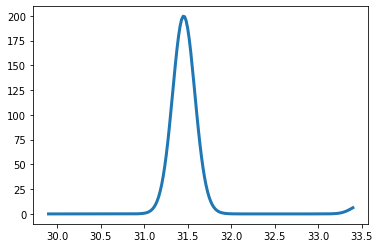

In [24]:
pred_curve0,integral = fit_model.eval_new(torch.tensor(t_plt,dtype=dtype,device=device))
plt.figure()
plt.plot(t_plt*1e9,pred_curve0.detach().numpy()*Ntrn,'-',label='$f(x)$',linewidth=3) # dh_bins*

In [25]:
fit_model.fit_coeff

Parameter containing:
tensor([[ 5.3937],
        [-5.2457],
        [-2.8724],
        [-0.5478],
        [ 5.0581],
        [ 3.4523],
        [ 3.7256],
        [ 0.5008],
        [ 2.3741],
        [-5.5439],
        [-5.2671]], dtype=torch.float64, requires_grad=True)

In [26]:
fit_model.treg.min()

tensor(-0.4643, dtype=torch.float64)

In [27]:
# set the loss function to use a 
# Poisson point process likelihood function
# loss_fn = pois_loss
loss_fn = pass_loss

In [28]:
# perform fit
epoch=0
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    loss = fit_model()
#     pred,integral = fit_model()
#     loss = loss_fn(pred,integral*Ntrn)  # add regularization here
    train_loss_lst +=[loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
#     pred_val,integral_val = fit_model.eval_vld()
#     loss_val = loss_fn(pred_val,integral_val*Nvld)
    loss_val = fit_model.vld_loss()
    valid_loss_lst +=[loss_val.item()]

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1

In [29]:
# calculate the validation loss.
# we would use this to determine optimimal tuning parameters
# if we had any (e.g. Polynomial Order)
loss_val = fit_model.vld_loss()
# pred_val,integral_val = fit_model.eval_vld()
# loss_val = loss_fn(pred_val,integral_val*Nvld)
print(f"Validation Loss: {loss_val}")

Validation Loss: tensor([-27824033.4607], dtype=torch.float64, grad_fn=<SubBackward0>)


In [30]:
rel_step

1.4419767131210115e-07

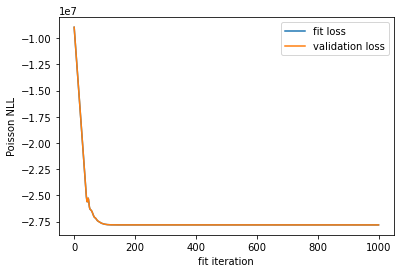

In [31]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

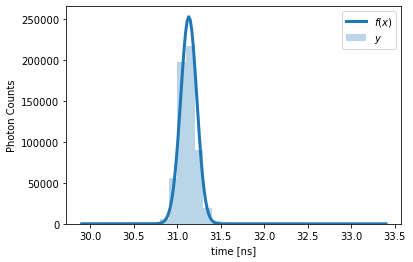

In [32]:
h_phot = np.histogram(t_det_trn,bins=np.arange(t_plt[0],t_plt[-1],100e-12))
dh_bins = np.median(np.diff(h_phot[1]))
pred_curve,integral = fit_model.eval_new(torch.tensor(t_plt,dtype=dtype,device=device))
plt.figure()
plt.bar(1e9*h_phot[1][:-1],h_phot[0],label='$y$',align='edge',width=1e9*np.diff(h_phot[1]),alpha=0.3)
plt.plot(t_plt*1e9,pred_curve.detach().numpy()*dh_bins*Ntrn,'-',label='$f(x)$',linewidth=3) # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Counts')
plt.legend()

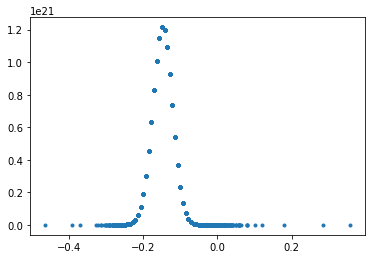

In [33]:
plt.figure()
plt.plot(fit_model.treg.detach().numpy(),fit_model.eval_model()[0].detach().numpy(),'.')

In [34]:
pred_curve2,integral2 = fit_model.eval_model()

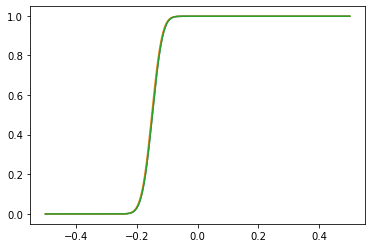

In [35]:
plt.figure()
plt.plot(fit_model.treg_int.detach().numpy(),integral.detach().numpy()*fit_model.dt_int)
plt.plot(fit_model.reg_time(t_plt),np.cumsum(pred_curve.detach().numpy())*np.mean(np.diff(t_plt)))
plt.plot(fit_model.treg_int.detach().numpy(),integral2.detach().numpy()*fit_model.dt_int)

In [36]:
np.trapz(pred_curve.detach().numpy().flatten(),t_plt)

0.9973123765805061

In [37]:
fit_model.dt_int

3.5035035035037535e-12

In [38]:
pred_curve.min()

tensor(2.1117e-15, dtype=torch.float64, grad_fn=<MinBackward1>)

## Gaussian Fit

In [29]:
# build the fit model as a NN module
class Fit_Pulse_Poisson(torch.nn.Module):
    def __init__(self,t_min,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(7*torch.ones(()))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-17.28*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-21.4*torch.ones(())) # Gaussian std
#         self.log_b = torch.nn.Parameter(0*torch.ones(()))      # background

        self.t_min = t_min # maximum time evaluated in integral term
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
#         b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = A*torch.exp(-(t-mu)**2/(2*sig**2)) # + b
        
        # calculate the integral
        integral_out_max = 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2)) # + b*self.t_max
        
        integral_out_min = 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_min-mu)/(sig*self.sqrt_2)) # + b*self.t_max
        
        integral_out = integral_out_max - integral_out_min
        
        return model_out, integral_out
    
# build the fit model as a NN module
class Fit_Pulse_Deadtime(torch.nn.Module):
    def __init__(self,t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(7*torch.ones(()))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-17.28*torch.ones(()))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-21.4*torch.ones(())) # Gaussian std
#         self.log_b = torch.nn.Parameter(0*torch.ones(()))      # background
        self.t_max = t_max # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t_det, t_arm):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)
        mu = torch.exp(self.log_mu)
        sig = torch.exp(self.log_sig)
#         b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = A*torch.exp(-(t_det-mu)**2/(2*sig**2)) # + b
        
        # calculate the integral
        integral_out_det = 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((t_det-mu)/(sig*self.sqrt_2)) # + b*self.t_max
        
        integral_out_arm = 0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((t_arm-mu)/(sig*self.sqrt_2))
        
        integral_out = integral_out_det - integral_out_arm
        
        return model_out, integral_out

In [30]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [31]:
# optimization parameters
rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [32]:
# initialize for fit loop
fit_model = Fit_Pulse_Poisson(min_time*1e-12,max_time*1e-12)
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

In [33]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [34]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred,integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred,integral*Ntrn)  # add regularization here
    train_loss_lst +=[loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
    pred_val,integral_val = fit_model(t_phot_val_tnsr)
    loss_val = loss_fn(pred_val,integral_val*Nvld)
    valid_loss_lst +=[loss_val.item()]

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1

In [35]:
# calculate the validation loss.
# we would use this to determine optimimal tuning parameters
# if we had any (e.g. more Gaussian targets)
pred_val,integral_val = fit_model(t_phot_val_tnsr)
loss_val = loss_fn(pred_val,integral_val*Nvld)
print(f"Validation Loss: {loss_val}")

Validation Loss: -11029614.977834657


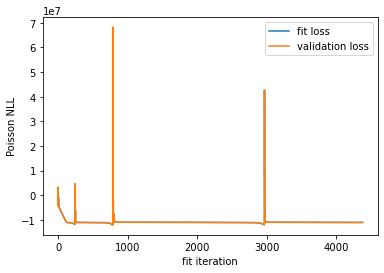

In [36]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

Display the resulting estimate

In [37]:
t_plt = np.linspace(min_time*1e-12,max_time*1e-12,200)
pred_mod_full,integral_full = fit_model(torch.tensor(t_plt))

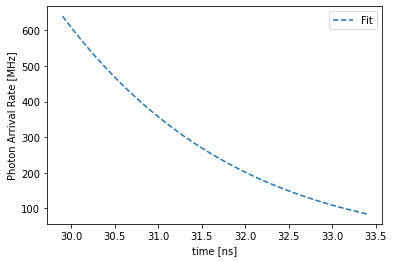

In [38]:
plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_plt*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

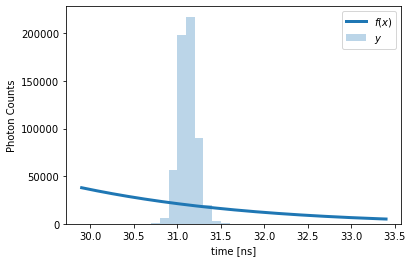

In [39]:
h_phot = np.histogram(t_det_trn,bins=np.arange(t_plt[0],t_plt[-1],100e-12))
dh_bins = np.median(np.diff(h_phot[1]))
plt.figure()
plt.bar(1e9*h_phot[1][:-1],h_phot[0],label='$y$',align='edge',width=1e9*np.diff(h_phot[1]),alpha=0.3)
plt.plot(t_plt*1e9,pred_mod_full.detach().numpy()*dh_bins*Ntrn,'-',label='$f(x)$',linewidth=3) # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Counts')
plt.legend()
# plt.xlim([400,1000])

In [324]:
dh_bins

1.000000000000009e-10

In [325]:
# calculate the modeled values at each photon arrival
pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

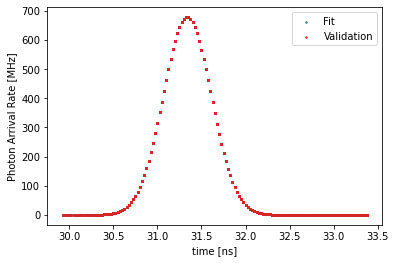

In [326]:
plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,s=2,label='Fit')
plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,s=2,label='Validation',c='tab:red')
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

# Multi Gaussian Model

In [327]:
# convert training and validation data to 
# tensor type
# t_phot_fit_tnsr = torch.tensor(t_phot_fit)
# t_phot_val_tnsr = torch.tensor(t_phot_val)

In [328]:
# build the fit model as a NN module
class Fit_MultiPulse(torch.nn.Module):
    def __init__(self,t_min,t_max,num_gaus):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(7+torch.randn(num_gaus))   # Gaussian amplitude
        self.log_mu = torch.nn.Parameter(-17.28+0.1*torch.ones(num_gaus))  # Gaussian mean
        self.log_sig = torch.nn.Parameter(-21.4+0.1*torch.ones(num_gaus)) # Gaussian std
#         self.log_b = torch.nn.Parameter(3+torch.randn(1))      # background
        self.t_max = t_max # maximum time evaluated in integral term
        self.t_min = t_min # maximum time evaluated in integral term
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        

    def forward(self, t):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)[None,:]
        mu = torch.exp(self.log_mu)[None,:]
        sig = torch.exp(self.log_sig)[None,:]
#         b = torch.exp(self.log_b)
        
        # calculate the forward model
        model_out = torch.sum(A*torch.exp(-(t[:,None]-mu)**2/(2*sig**2)),dim=1) # + b
        
        # calculate the integral
        integral_out_max = torch.sum(0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_max-mu)/(sig*self.sqrt_2)),dim=1) # + b*self.t_max
        integral_out_min = torch.sum(0.5*A*sig*self.sqrt_2pi \
                        + 0.5*A*sig*self.sqrt_2pi\
                            *torch.special.erf((self.t_min-mu)/(sig*self.sqrt_2)),dim=1) # + b*self.t_max
        
        integral_out = integral_out_max - integral_out_min
        
        return model_out, integral_out

In [329]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [330]:
# optimization parameters
rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [331]:
# initialize for fit loop
fit_model = Fit_MultiPulse(min_time*1e-12,max_time*1e-12,3)
optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
epoch=0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
valid_loss_lst = []
rel_step_lst = []

In [332]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [333]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred,integral = fit_model(t_phot_fit_tnsr)
    loss = loss_fn(pred,integral*Ntrn)  # add regularization here
    train_loss_lst +=[loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())
    
    # calculate validation loss... for fun
    pred_val,integral_val = fit_model(t_phot_val_tnsr)
    loss_val = loss_fn(pred_val,integral_val*Nvld)
    valid_loss_lst +=[loss_val.item()]

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()

#     print(f"{train_loss_lst[-1]}")
    
    epoch+=1

In [334]:
# calculate the validation loss.
# we would use this to determine optimimal tuning parameters
# if we had any (e.g. more Gaussian targets)
pred_val,integral_val = fit_model(t_phot_val_tnsr)
loss_val = loss_fn(pred_val,integral_val*Nvld)
print(f"Validation Loss: {loss_val}")

Validation Loss: tensor([-5128184.5000], grad_fn=<SubBackward0>)


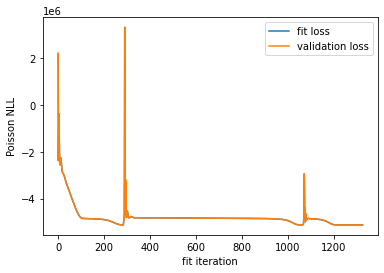

In [335]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.plot(valid_loss_lst,label='validation loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

Display the resulting estimate

In [336]:
pred_mod_full,integral_full = fit_model(torch.tensor(t_plt))

In [337]:
fit_model.log_A

Parameter containing:
tensor([20.3081, 19.0101, 20.3757], requires_grad=True)

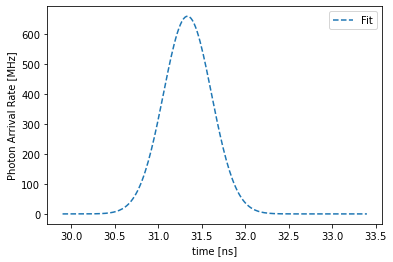

In [338]:
plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_plt*1e9,pred_mod_full.detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

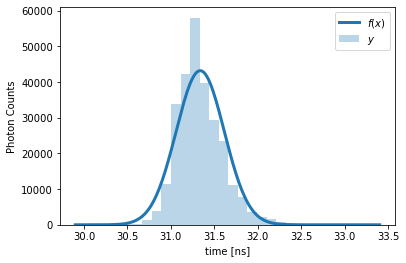

In [339]:
h_phot = np.histogram(t_det_trn,bins=np.arange(t_plt[0],t_plt[-1],110e-12))
dh_bins = np.median(np.diff(h_phot[1]))
plt.figure()
plt.bar(1e9*h_phot[1][:-1],h_phot[0],label='$y$',align='edge',width=1e9*np.diff(h_phot[1]),alpha=0.3)
plt.plot(t_plt*1e9,pred_mod_full.detach().numpy()*dh_bins*Ntrn,'-',label='$f(x)$',linewidth=3) # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Counts')
plt.legend()

In [340]:
# calculate the modeled values at each photon arrival
pred_mod_fit_pts,integral_fit_pts = fit_model(t_phot_fit_tnsr)
pred_mod_val_pts,integral_val_pts = fit_model(t_phot_val_tnsr)

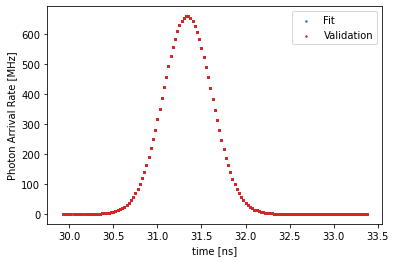

In [341]:
plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual',color='k',alpha=0.3)
plt.scatter(t_phot_fit_tnsr.detach().numpy()*1e9,pred_mod_fit_pts.detach().numpy()*1e-6,s=2,label='Fit')
plt.scatter(t_phot_val_tnsr.detach().numpy()*1e9,pred_mod_val_pts.detach().numpy()*1e-6,s=2,label='Validation',c='tab:red')
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

## Optimize number of Gaussians

In [342]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [343]:
# optimization parameters
rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
repeat_count = 30     # number of times to repeat the initialization
max_mode_count = 10   # max number of Gaussian modes to evaluate

In [344]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [345]:
sol_lst = []
fit_lst = []
vld_lst = []
epoch_lst = []
num_gaus_lst = []

In [ ]:
for num_gaussian in range(1,max_mode_count):
    for init_cnt in range(repeat_count):
        # initialize for fit loop
        fit_model = Fit_MultiPulse(min_time*1e-12,max_time*1e-12,num_gaussian)
        optimizer = torch.optim.Adam(fit_model.parameters(),lr=learning_rate)
        epoch=0
        rel_step = 1e3*rel_step_lim
        train_loss_lst = []
        valid_loss_lst = []
        rel_step_lst = []

        # perform fit
        while rel_step > rel_step_lim and epoch < max_epochs:
            fit_model.train()
            pred,integral = fit_model(t_phot_fit_tnsr)
            loss = loss_fn(pred,integral*Ntrn)  # add regularization here
            train_loss_lst +=[loss.item()]

            # calculate relative step as an average over the last
            # term_persist iterations
            if epoch == 0:
                rel_step_lst+=[1e3*rel_step_lim]
                rel_step = 1e3*rel_step_lim
            else:
                rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
                rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

            # calculate validation loss... for fun
            pred_val,integral_val = fit_model(t_phot_val_tnsr)
            loss_val = loss_fn(pred_val,integral_val*Nvld)
            valid_loss_lst +=[loss_val.item()]

            # update estimated parameters
            loss.backward()
            optimizer.step()

            # zero out the gradient for the next step
            optimizer.zero_grad()

        #     print(f"{train_loss_lst[-1]}")

            epoch+=1

        # calculate the validation loss.
        # we would use this to determine optimimal tuning parameters
        # if we had any (e.g. more Gaussian targets)
        pred_val,integral_val = fit_model(t_phot_val_tnsr)
        loss_val = loss_fn(pred_val,integral_val*Nvld)
#         print(f"{num_gaussian} modes, Validation Loss: {loss_val.item()}")

        pred_mod_full,integral_full = fit_model(torch.tensor(t_plt))

        sol_lst.append(fit_model.parameters())
        fit_lst.append(pred_mod_full)
        vld_lst.append(loss_val.item())
        num_gaus_lst.append(num_gaussian)
        epoch_lst.append(epoch)
    print(f"{num_gaussian} modes")

1 modes
2 modes
3 modes
4 modes
5 modes


In [ ]:
isol = np.argmin(vld_lst)

In [ ]:
vld_arr = np.array(vld_lst).reshape(-1,repeat_count)
# num_gaus_arr = np.array(num_gaus_lst).reshape(-1,repeat_count,)

In [ ]:
plt.figure()
plt.plot(num_gaus_lst[isol],vld_lst[isol],'o',color='tab:orange')
plt.plot(num_gaus_lst,vld_lst,'.',color='tab:blue')
plt.xlabel("Gaussian Modes")
plt.ylabel("Validation NLL")


# plt.figure()
# # plt.plot(num_gaus_lst[isol],vld_lst[isol],'o',color='tab:orange')
# plt.plot(np.mean(num_gaus_arr,axis=1),np.min(vld_arr,axis=1),'.',color='tab:blue')
# plt.xlabel("Gaussian Modes")
# plt.ylabel("Validation NLL")



In [ ]:
plt.figure()
# plt.plot(t_sim*1e9,photon_rate_arr*1e-6,label='Actual')
plt.plot(t_plt*1e9,fit_lst[isol].detach().numpy()*1e-6,'--',label='Fit') # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Arrival Rate [MHz]')
plt.legend()

In [ ]:
for param in sol_lst[isol]:
    print(torch.exp(param))

In [ ]:
sol_lst[isol]

In [ ]:
h_phot = np.histogram(t_det_trn,bins=np.arange(t_plt[0],t_plt[-1],110e-12))
dh_bins = np.median(np.diff(h_phot[1]))
plt.figure()
plt.bar(1e9*h_phot[1][:-1],h_phot[0],label='$y$',align='edge',width=1e9*np.diff(h_phot[1]),alpha=0.3)
plt.plot(t_plt*1e9,fit_lst[isol].detach().numpy()*dh_bins*Ntrn,'-',label='$f(x)$',linewidth=3) # /cnt_phot_fit
plt.xlabel('time [ns]')
plt.ylabel('Photon Counts')
plt.legend()

In [193]:
ds.close()